# Yelp Would Know What You Like 

Group Member:  Guoxiangchi He, Sijin Zhou, Yuying Shi

# Problem Description

This is a recommendation system based on existed users and business information, giving potential business choices to users they never been before and would be interested in.
    
More specifically, we use Classification, Regression models which are based on business information and user information. And ALS  model which focus only on review stars.

# Dataset Description

Data source: https://www.yelp.com/dataset 

Three json. data files: 

User.json contains each user basic information like joining yelp time/name/fans/friends and  personal evaluation giving to business like average stars/review counts. (1,968,703*22)

Business.json contains each business basic information like opening time/geographical location/categories and public evaluation they received  like average stars/review counts. (1,968,703*19 )

Review.json contains each review text & star from one user to one specific business. (8,021,122*8)


In [2]:
# create spark session
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate() 
sc = spark.sparkContext

In [3]:
# read json files with Spark
#reference: https://spark.apache.org/docs/latest/sql-data-sources-json.html
businesspath = "yelp_academic_dataset_business.json"
businessdf = spark.read.json(businesspath)
userpath="yelp_academic_dataset_user.json"
userdf = spark.read.json(userpath)
reviewpath="yelp_academic_dataset_review.json"
reviewdf=spark.read.json(reviewpath)

## 1. EDA:review part selection

Firstly, we need to see each tables information. We have three different tables seprately, they are 'businessdf', 'userdf', and 'reviewdf'

For the reviewdf below, we have 8021122 rows and 9 columns. 'business_id' and 'user_id' will be used for joining the other two tables, while the 'stars' is the column we will predict. So we will keep those three columns for the following research. For the other columns, like 'cool','funny','useful','date' etc won't have important influence on our model, so we will not select those columns as our feature.

In [55]:
reviewdf.limit(3).toPandas()

,business_id,cool,date,funny,review_id,stars,text,useful,user_id
0,-MhfebM0QIsKt87iDN-FNw,0,2015-04-15 05:21:16,0,xQY8N_XvtGbearJ5X4QryQ,2.0,"As someone who has worked with many museums, I...",5,OwjRMXRC0KyPrIlcjaXeFQ
1,lbrU8StCq3yDfr-QMnGrmQ,0,2013-12-07 03:16:52,1,UmFMZ8PyXZTY2QcwzsfQYA,1.0,I am actually horrified this place is still in...,1,nIJD_7ZXHq-FX8byPMOkMQ
2,HQl28KMwrEKHqhFrrDqVNQ,0,2015-12-05 03:18:11,0,LG2ZaYiOgpr2DK_90pYjNw,5.0,I love Deagan's. I do. I really do. The atmosp...,1,V34qejxNsCbcgD8C0HVk-Q


In [4]:
review_data = reviewdf.dropna()
print((review_data.count(), len(review_data.columns)))

(8021122, 9)


In [5]:
from pyspark.sql import functions as fn
review_df_selected = review_data.select('business_id','user_id','text',fn.col('stars').alias('review_stars'))

## 2. EDA:business part selection

Secondly, for businessdf, we visulized the numeric columns to see their density. We can find that 'review_count' has a very sparse distribution, almost 90% of the column focuses on 1-100 reviews, which also make our dataset has right skewness.

For the star column, the distribution focuses on 4.

For the category column, we use wordcloud to countour the information, most are beauty and health businesses.

For the attribute column, in order to reduce the sparsity of the dataset, we select sub_attributes that have null value under 60%, they are BikeParking, BusinessParking, BusinessAcceptCreditCard and RestaurantPriceRange. Those columns will be used in our final modek to predit review stars.

Then we use sns to visulize the numeric data and add those four attributes as hue. From this visulization, we can identify most business price range focuses on range 2

### (1) visualization

In [6]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146796 entries, 0 to 146795
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   address       146796 non-null  object 
 1   attributes    146796 non-null  object 
 2   business_id   146796 non-null  object 
 3   categories    146796 non-null  object 
 4   city          146796 non-null  object 
 5   hours         146796 non-null  object 
 6   is_open       146796 non-null  int64  
 7   latitude      146796 non-null  float64
 8   longitude     146796 non-null  float64
 9   name          146796 non-null  object 
 10  postal_code   146796 non-null  object 
 11  review_count  146796 non-null  int64  
 12  stars         146796 non-null  float64
 13  state         146796 non-null  object 
dtypes: float64(3), int64(2), object(9)
memory usage: 15.7+ MB


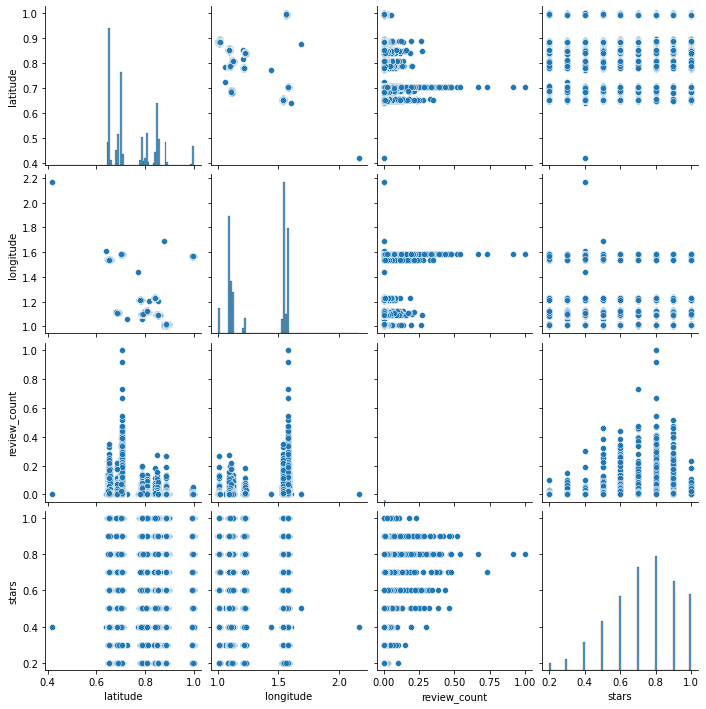

/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


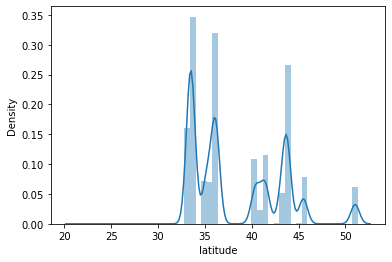

/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


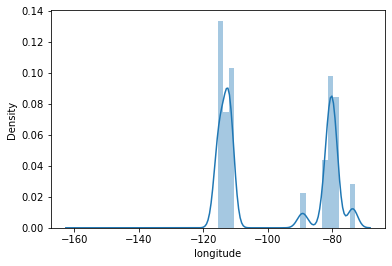

/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


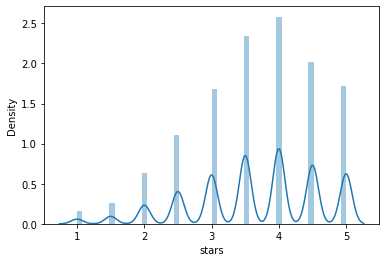

/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


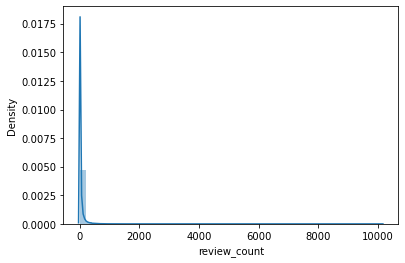

In [7]:
#numeric features visulization
business_df = businessdf.dropna().toPandas()

business_df['review_count']=business_df['review_count'].fillna(0)
business_df['stars']=business_df['stars'].fillna(0)

business_df.describe()
stars = business_df.groupby('stars').mean()
stars.corr()

business_df.info()

numeric_features = business_df.loc[:, ['latitude', 'longitude', 'review_count', 'stars']]
numeric_features_standardized = (numeric_features)/numeric_features.max()
ax = sns.pairplot(numeric_features_standardized)
plt.show()

ax = sns.distplot(business_df['latitude'])
plt.show()
ax = sns.distplot(business_df['longitude'])
plt.show()
ax = sns.distplot(business_df['stars'])
plt.show()
ax = sns.distplot(business_df['review_count'])
plt.show()



In [60]:
businessdf.limit(3).toPandas()

,address,attributes,business_id,categories,city,hours,is_open,latitude,longitude,name,postal_code,review_count,stars,state
0,10913 Bailey Rd,"(None, None, None, None, None, None, None, Tru...",f9NumwFMBDn751xgFiRbNA,"Active Life, Gun/Rifle Ranges, Guns & Ammo, Sh...",Cornelius,"(11:0-20:0, 10:0-18:0, 11:0-20:0, 13:0-18:0, 1...",1,35.462724,-80.852612,The Range At Lake Norman,28031,36,3.5,NC
1,"8880 E Via Linda, Ste 107","(None, None, None, None, None, None, None, Non...",Yzvjg0SayhoZgCljUJRF9Q,"Health & Medical, Fitness & Instruction, Yoga,...",Scottsdale,None,1,33.569404,-111.890264,"Carlos Santo, NMD",85258,4,5.0,AZ
2,3554 Rue Notre-Dame O,None,XNoUzKckATkOD1hP6vghZg,"Pets, Pet Services, Pet Groomers",Montreal,None,1,45.479984,-73.580070,Felinus,H4C 1P4,5,5.0,QC


In [61]:
#categories word clound

In [62]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [63]:
pip install wordcloud

Note: you may need to restart the kernel to use updated packages.


In [64]:
pip install pandas

Note: you may need to restart the kernel to use updated packages.


In [65]:
# importing all necessery modules
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import pandas as pd

In [66]:
business_pd = businessdf.toPandas()

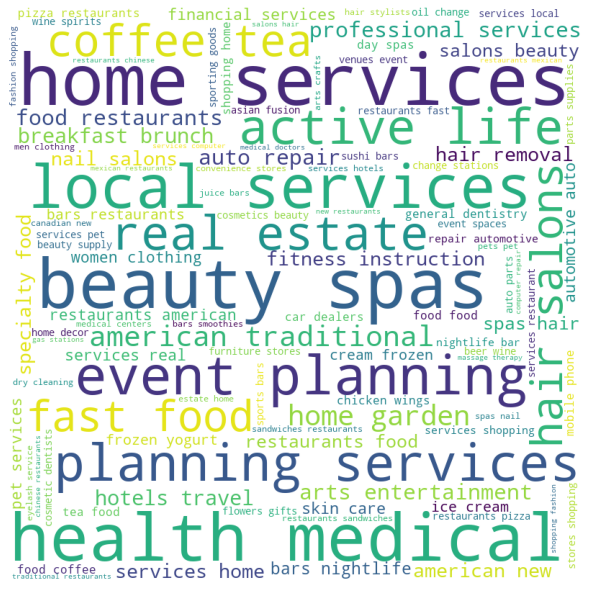

In [67]:
# iterate through business_df categories
comment_words = ''
stopwords = set(STOPWORDS)

for val in business_pd.categories:
      
    # typecaste each val to string
    val = str(val)
  
    # split the value
    tokens = val.split()
      
    # Converts each token into lowercase
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
      
    comment_words += " ".join(tokens)+" "
  
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(comment_words)
  
# plot the WordCloud image                       
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
  
plt.show()

In [68]:
#businessdf numeric variables scatter plot

In [69]:
from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()
business_pd['state'] = label_encoder.fit_transform(business_pd['state'])

In [70]:
label_encoder = preprocessing.LabelEncoder()
business_pd['city'] = label_encoder.fit_transform(business_pd['city'])

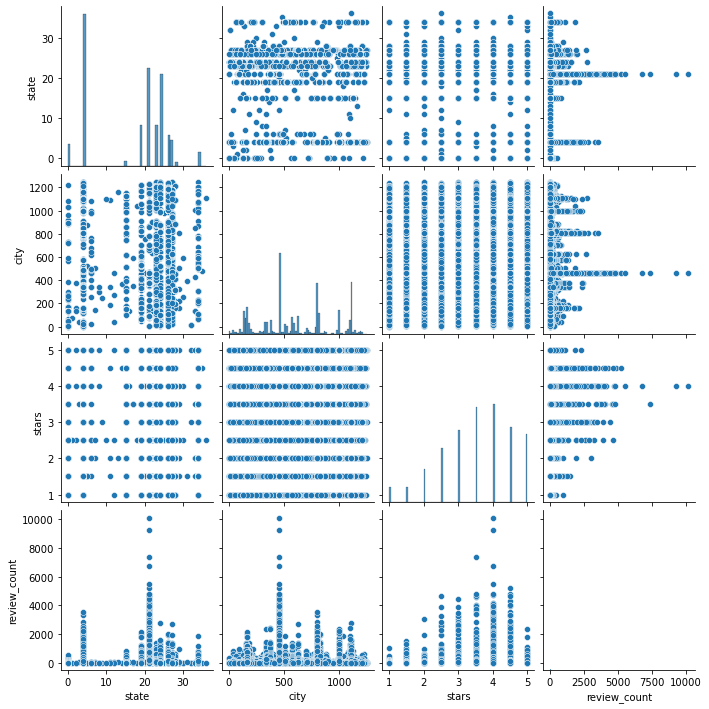

In [71]:
sns.pairplot(business_pd[['state', 'city', 'stars', 'review_count']])

### (2) feature engineering: attributes

In [8]:
# Here we build a dataframe about each element inside 'attributes' and their "null rate", then filter based on null rate
from pyspark.sql.functions import isnull
businessatt=businessdf.select('attributes.*')
nulllist=[]
for e in businessatt.schema:
    d={}
    d['attribute_name']=e.name
    d['null_rate']=businessatt.where(isnull('attributes.'+e.name)).count()/businessatt.count()
    nulllist.append(d)
null_rate_df=spark.createDataFrame(nulllist).where(fn.col('null_rate')<0.6).orderBy('null_rate',ascending=False)
null_rate_df.show()
print(list(null_rate_df.select('attribute_name').toPandas()['attribute_name']))

/opt/conda/lib/python3.8/site-packages/pyspark/sql/session.py:381: UserWarning: inferring schema from dict is deprecated,please use pyspark.sql.Row instead
  warnings.warn("inferring schema from dict is deprecated,"


+--------------------+-------------------+
|      attribute_name|          null_rate|
+--------------------+-------------------+
|         BikeParking| 0.5713084964635876|
|RestaurantsPriceR...| 0.4685209152168411|
|     BusinessParking| 0.4497667066234306|
|BusinessAcceptsCr...|0.41623167918698334|
+--------------------+-------------------+

['BikeParking', 'RestaurantsPriceRange2', 'BusinessParking', 'BusinessAcceptsCreditCards']


In [9]:
from pyspark.sql.functions import when, split
import functools
from functools import reduce
# BikeParking, RestaurantsPriceRange2, BusinessAcceptsCreditCards
businessdf1=businessdf.select('business_id',fn.col('stars').alias('business_average_stars'),'categories','state','city','review_count','attributes.BusinessParking',
                             when(fn.col('attributes.BikeParking')=='True',1).otherwise(0).alias('BikeParking'),
                             when((isnull(fn.col('attributes.RestaurantsPriceRange2')))|(fn.col('attributes.RestaurantsPriceRange2')=='None'),0).otherwise(fn.col('attributes.RestaurantsPriceRange2')).alias('RestaurantsPriceRange'),
                             when(fn.col('attributes.BusinessAcceptsCreditCards')=='True',1).otherwise(0).alias('BusinessAcceptsCreditCards'))
# BusinessParking
bus_park = businessdf1.withColumn('garage', split(businessdf1['BusinessParking'], ',').getItem(0))\
        .withColumn('street', split(businessdf1['BusinessParking'], ',').getItem(1)) \
        .withColumn('validated', split(businessdf1['BusinessParking'], ',').getItem(2))\
        .withColumn('lot', split(businessdf1['BusinessParking'], ',').getItem(3)) \
        .withColumn('valet', split(businessdf1['BusinessParking'], ',').getItem(4))
bus_park2 = bus_park\
        .withColumn('garage', split(bus_park['garage'], ':').getItem(1))\
        .withColumn('street', split(bus_park['street'], ':').getItem(1)) \
        .withColumn('validated', split(bus_park['validated'], ':').getItem(1))\
        .withColumn('lot', split(bus_park['lot'], ':').getItem(1)) \
        .withColumn('valet', split(bus_park['valet'], ':').getItem(1))

bus_park3 = bus_park2.withColumn('valet', split(bus_park2['valet'], '}').getItem(0))

cols = ['garage','street','validated','lot','valet']
bus_park4 = reduce(lambda bus_park3, c: bus_park3.withColumn(c, fn.when(bus_park3[c] == True, 1).otherwise(0)), cols, bus_park3)\
             .withColumn('Bussiness_Park_Sum',sum([fn.col(c) for c in cols]))

In [10]:
business_df_selected = bus_park4.select('business_id','business_average_stars','categories','state','city',fn.col('review_count').alias('business_review_count'),'Bussiness_Park_Sum',
                              'BikeParking','RestaurantsPriceRange','BusinessAcceptsCreditCards')
business_df_selected.toPandas().head(3)

,business_id,business_average_stars,categories,state,city,business_review_count,Bussiness_Park_Sum,BikeParking,RestaurantsPriceRange,BusinessAcceptsCreditCards
0,f9NumwFMBDn751xgFiRbNA,3.5,"Active Life, Gun/Rifle Ranges, Guns & Ammo, Sh...",NC,Cornelius,36,1,1,3,1
1,Yzvjg0SayhoZgCljUJRF9Q,5.0,"Health & Medical, Fitness & Instruction, Yoga,...",AZ,Scottsdale,4,0,0,0,0
2,XNoUzKckATkOD1hP6vghZg,5.0,"Pets, Pet Services, Pet Groomers",QC,Montreal,5,0,0,0,0


In [75]:
#pair plot 

In [76]:
from pyspark.sql.types import IntegerType,StringType
business_df_selected1 = business_df_selected\
                    .withColumn("Bussiness_Park_Sum1", business_df_selected["Bussiness_Park_Sum"].cast(StringType()))\
                    .withColumn("BikeParking1", business_df_selected["BikeParking"].cast(StringType()))\
                    .withColumn("RestaurantsPriceRange1", business_df_selected["RestaurantsPriceRange"].cast(StringType()))\
                    .withColumn("BusinessAcceptsCreditCards1", business_df_selected["BusinessAcceptsCreditCards"].cast(StringType()))

business_df_selected2 = business_df_selected1.select('business_average_stars','business_review_count','Bussiness_Park_Sum1'\
                                                    ,'BikeParking1','RestaurantsPriceRange1','BusinessAcceptsCreditCards1')

In [77]:
business_df_selected2.printSchema()

root
 |-- business_average_stars: double (nullable = true)
 |-- business_review_count: long (nullable = true)
 |-- Bussiness_Park_Sum1: string (nullable = false)
 |-- BikeParking1: string (nullable = false)
 |-- RestaurantsPriceRange1: string (nullable = true)
 |-- BusinessAcceptsCreditCards1: string (nullable = false)



In [78]:
newdf = business_df_selected2.toPandas()

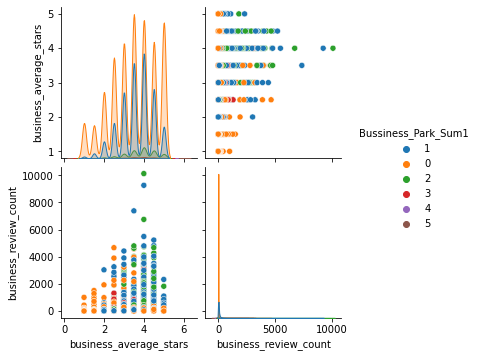

In [79]:
sns.pairplot(newdf,
             hue = 'Bussiness_Park_Sum1')

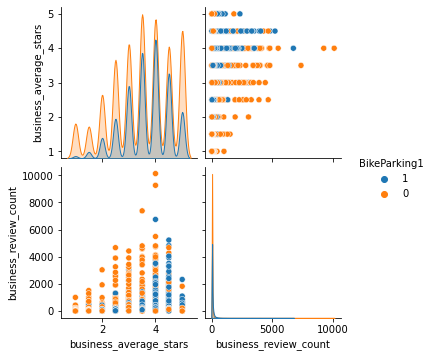

In [80]:
sns.pairplot(newdf,
             hue = 'BikeParking1')

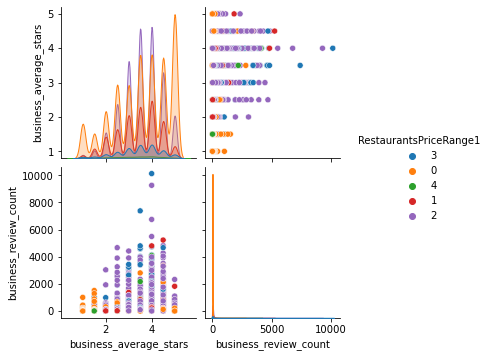

In [81]:
sns.pairplot(newdf,
             hue = 'RestaurantsPriceRange1')

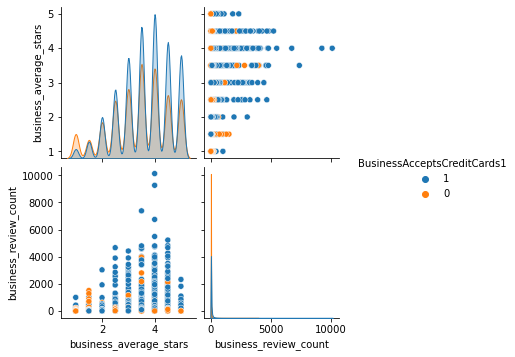

In [82]:
sns.pairplot(newdf,
             hue = 'BusinessAcceptsCreditCards1')

## 3. user part selection

For this table, we majorly need to use the user_id column to combine the other two tables.

The features we decided to keep are 'user_id', 'user_average_stars', 'user_join_year','user_review_count' and 'useful'

In [83]:
userdf.printSchema()

root
 |-- average_stars: double (nullable = true)
 |-- compliment_cool: long (nullable = true)
 |-- compliment_cute: long (nullable = true)
 |-- compliment_funny: long (nullable = true)
 |-- compliment_hot: long (nullable = true)
 |-- compliment_list: long (nullable = true)
 |-- compliment_more: long (nullable = true)
 |-- compliment_note: long (nullable = true)
 |-- compliment_photos: long (nullable = true)
 |-- compliment_plain: long (nullable = true)
 |-- compliment_profile: long (nullable = true)
 |-- compliment_writer: long (nullable = true)
 |-- cool: long (nullable = true)
 |-- elite: string (nullable = true)
 |-- fans: long (nullable = true)
 |-- friends: string (nullable = true)
 |-- funny: long (nullable = true)
 |-- name: string (nullable = true)
 |-- review_count: long (nullable = true)
 |-- useful: long (nullable = true)
 |-- user_id: string (nullable = true)
 |-- yelping_since: string (nullable = true)



In [11]:
# change join year from str to integer to one-hot encoding
from pyspark.sql.functions import substring
from pyspark.sql import functions as fn
from pyspark.sql.types import IntegerType
user_df_selected=userdf.withColumn('user_join_year',substring(fn.col('yelping_since'),1,4).cast(IntegerType())).\
                 select(['user_id',fn.col('average_stars').alias('user_average_stars'),'user_join_year',fn.col('review_count').alias('user_review_count'),'useful'])

In [85]:
user_df_selected.limit(3).toPandas()

,user_id,user_average_stars,user_join_year,user_review_count,useful
0,ntlvfPzc8eglqvk92iDIAw,3.57,2007,553,628
1,FOBRPlBHa3WPHFB5qYDlVg,3.84,2008,564,790
2,zZUnPeh2hEp0WydbAZEOOg,3.44,2008,60,151


## 4. join 3 dataframes

After pre-processing each dataframes and visualize them, we can combine these 3 dataframes by the common "business_id" and "user_id", then apply some filters:
1. 'user_review_count' and 'business_review_count' are right-skewed, if we include all of them, most of data will be close to 0 after we apply minmaxscaler to them. So we limit the range to 0-50. This also keeps the most data.
2. Limit the city to "Las Vegas"
We can have a look at the overall structure of combineddf. We have 241239 rows left, still pretty much.

In [12]:
combineddf = business_df_selected.join(review_df_selected, on='business_id').join(user_df_selected,on='user_id')
# set boundary to remove outliers of review_count of user and business
combineddf = combineddf.withColumn('user_review_count',combineddf.user_review_count.cast('int')).\
                        withColumn('business_review_count',combineddf.business_review_count.cast('int')).\
                        withColumn('RestaurantsPriceRange',combineddf.RestaurantsPriceRange.cast('int')).\
                        where(fn.col('user_review_count')<50).where(fn.col('business_review_count')<50).\
                        where(fn.col('city')=="Las Vegas")

In [87]:
combineddf.toPandas().head(3)

,user_id,business_id,business_average_stars,categories,state,city,business_review_count,Bussiness_Park_Sum,BikeParking,RestaurantsPriceRange,BusinessAcceptsCreditCards,text,review_stars,user_average_stars,user_join_year,user_review_count,useful
0,-1zQA2f_syMAdA04PUWNNw,sAS4fHDiK8A9a1wEAj4S3w,3.5,"Personal Assistants, Local Services, IT Servic...",NV,Las Vegas,27,0,0,0,1,Horrible business. Very unethical. \n\nMathew ...,1.0,3.29,2014,7,8
1,-9aj4KK4lLzoP33E5hzJ5w,EmnaFpPHQd-OUkogW2cILA,5.0,"Skin Care, Beauty & Spas",NV,Las Vegas,9,0,1,2,1,It definitely was not as painful as I was expe...,5.0,5.00,2014,2,1
2,-EF-8DMD3qD1z1oBIbeFlw,_O5zubqsiY9kEaNAmR-24w,5.0,"Food, Desserts, Cupcakes, Bakeries, Farmers Ma...",NV,Las Vegas,32,1,1,1,1,She made the best and the most beautiful cake ...,5.0,5.00,2012,1,4


In [88]:
combineddf.count()

241239

In [89]:
combineddf.printSchema()

root
 |-- user_id: string (nullable = true)
 |-- business_id: string (nullable = true)
 |-- business_average_stars: double (nullable = true)
 |-- categories: string (nullable = true)
 |-- state: string (nullable = true)
 |-- city: string (nullable = true)
 |-- business_review_count: integer (nullable = true)
 |-- Bussiness_Park_Sum: integer (nullable = false)
 |-- BikeParking: integer (nullable = false)
 |-- RestaurantsPriceRange: integer (nullable = true)
 |-- BusinessAcceptsCreditCards: integer (nullable = false)
 |-- text: string (nullable = true)
 |-- review_stars: double (nullable = true)
 |-- user_average_stars: double (nullable = true)
 |-- user_join_year: integer (nullable = true)
 |-- user_review_count: integer (nullable = true)
 |-- useful: long (nullable = true)



We can have a look at correlation matrix. This gives us some hints about which feature have closer relationship to review_stars. This is useful to feature engineering.

In [91]:
corr = combineddf.toPandas().corr()

In [92]:
corr

,business_average_stars,business_review_count,Bussiness_Park_Sum,BikeParking,RestaurantsPriceRange,BusinessAcceptsCreditCards,review_stars,user_average_stars,user_join_year,user_review_count,useful
business_average_stars,1.000000,0.005464,0.067343,0.070925,-0.028525,0.094349,0.595303,0.387842,-0.072920,0.019032,-0.016797
business_review_count,0.005464,1.000000,0.204354,0.200422,0.168448,0.225296,0.002799,0.011145,0.015587,0.016352,0.000477
Bussiness_Park_Sum,0.067343,0.204354,1.000000,0.470069,0.457862,0.228778,0.038880,0.038992,-0.063865,0.050728,0.024523
BikeParking,0.070925,0.200422,0.470069,1.000000,0.463514,0.263186,0.038424,0.030777,0.023510,0.028372,-0.010951
RestaurantsPriceRange,-0.028525,0.168448,0.457862,0.463514,1.000000,0.326119,-0.021467,0.000717,-0.081990,0.065917,0.031225
BusinessAcceptsCreditCards,0.094349,0.225296,0.228778,0.263186,0.326119,1.000000,0.052488,0.049468,-0.020325,0.028178,0.000049
review_stars,0.595303,0.002799,0.038880,0.038424,-0.021467,0.052488,1.000000,0.620982,-0.073892,0.036239,-0.028269
user_average_stars,0.387842,0.011145,0.038992,0.030777,0.000717,0.049468,0.620982,1.000000,-0.089137,0.054068,-0.045402
user_join_year,-0.072920,0.015587,-0.063865,0.023510,-0.081990,-0.020325,-0.073892,-0.089137,1.000000,-0.332721,-0.329024
user_review_count,0.019032,0.016352,0.050728,0.028372,0.065917,0.028178,0.036239,0.054068,-0.332721,1.000000,0.602256


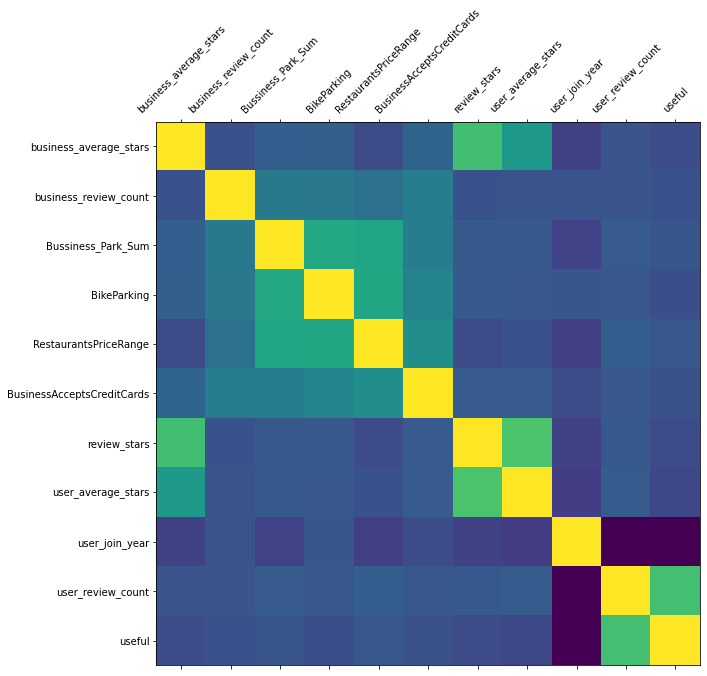

In [93]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.matshow(corr)
plt.xticks(range(len(corr.columns)), corr.columns, rotation=45);
plt.yticks(range(len(corr.columns)), corr.columns);

plt.show()

## 5. separate dataset, feature engineering

First, we separate the combined dataframe into 3 part: training dataset:validation dataset:testing dataset=6:3:1. We use training dataset to train model and find best combination of parameters, then we transform the validation dataset to find best model among several models, and then transform the testing dataset to find out the performance of this best model on unseen records.

In feature engineering, we can get some hints from the correlation matrix. Since our "y" is review_stars, we can find that "business_average_stars" and "user_average_stars" have high correlation with "review_stars", but other features have correlation less than 0.1. So here is the steps:
1. apply one-hot encodding to "user_join_year" to treat each year equally
2. apply minmaxscaler on "business_review_count" and "user_review_count" to change range to 0-1.
3. apply PCA to features other than "business_average_stars" and "user_average_stars" to find top 3 useful features among those "weak" features.
4. Combine this 3 features to "business_average_stars" and "user_average_stars" as final features to use in model

In [13]:
from pyspark.ml import Pipeline, classification, evaluation, feature
from pyspark.ml.tuning import TrainValidationSplit, ParamGridBuilder

training_df, validation_df, testing_df = combineddf.randomSplit([0.6, 0.3, 0.1], seed=0)

OneHotEncoder1=feature.OneHotEncoder(inputCol='user_join_year',outputCol='user_join_year01')
VectorAssembler1=feature.VectorAssembler(inputCols=['business_review_count','user_review_count'],outputCol='feature1')
MinMaxScaler=feature.MinMaxScaler(inputCol='feature1',outputCol='feature2')
VectorAssembler2=feature.VectorAssembler(inputCols=['feature2','Bussiness_Park_Sum','BikeParking','RestaurantsPriceRange','BusinessAcceptsCreditCards','user_join_year01'],outputCol='feature3')
PCA=feature.PCA(k=3,inputCol='feature3',outputCol='pca')
VectorAssembler3=feature.VectorAssembler(inputCols=['business_average_stars','user_average_stars','pca'],outputCol='features')


FeaturePipeline=Pipeline(stages=[OneHotEncoder1,
                                 VectorAssembler1,
                                 MinMaxScaler,
                                 VectorAssembler2,
                                 PCA,
                                 VectorAssembler3]).fit(combineddf)

## 6. Classification

First, we can treat this as a classification task: the review_stars can only be integer 1,2,3,4,5, we can treat each number as a category.Based on basic information (features) of user and business, we can build and combine different classification models to classify each record to different categories.

The classification models that we use are: logistic regression, decision tree, random forest.

Since we have multiple categories here, we use MulticlassClassificationEvaluator. Since the number of records in each categories are unbalanced, so we use AUC as evaluation method.

The overall structure is: 
1. combine feature engineering and classification model in a pipeline 
2. use ParamGridBuilder and TrainValidationSplit to set different values to each parameter. After fitting the training dataset, it will privide the best set of parameters to us.
    1. logistic regression: regParam=0.01/0.05/0.1; elasticNetParam=0.3/0.5/0.7
    2. decision tree: maxDepth=5/10/15/20/25/30
    3. random forest: maxDepth=5/10; numTrees=5/10
3. print and show the best value of each parameter
    1. logistic regression: regParam=0.01, elasticNetParam=0.7
    2. decision tree: maxDepth=10
    3. random forest: maxDepth=10, numTrees=5
4. use the best model of each classification model to transform validation dataset. By compairing different classification models, we can find the best type (decision tree here).
    1. AUC for logistic regression: 0.697558890228659
    2. AUC for decision tree: **0.6999904210135934**
    3. AUC for random forest: 0.698880653895671
5. transform the testing dataset, you can find that decision tree also performs better.

In [14]:
ClassificationEvaluator = evaluation.MulticlassClassificationEvaluator(labelCol='review_stars')

### (1) Logisic Regression

In [15]:
%%time

LogisticRegression=classification.LogisticRegression(featuresCol='features',labelCol='review_stars')
LogisticRegressionPipeline=Pipeline(stages=[FeaturePipeline,LogisticRegression])

LogisticRegression_param_grid = ParamGridBuilder().addGrid(LogisticRegression.regParam,[0.01,0.05,0.1])\
                               .addGrid(LogisticRegression.elasticNetParam,[0.3,0.5,0.7]).build()

# Build cross validation using TrainValidationSplit
LogisticRegression_tvs = TrainValidationSplit(estimator = LogisticRegressionPipeline,
                                              estimatorParamMaps=LogisticRegression_param_grid,
                                              evaluator=ClassificationEvaluator)

# Fit ALS model to training data
LogisticRegressionModel = LogisticRegression_tvs.fit(training_df)

# best model
LogisticRegression_BestModel = LogisticRegressionModel.bestModel

print("-------------Best parameters for Logistic Regression---------------")
print("regParam: ",LogisticRegression_BestModel.stages[-1].getRegParam())
print("elasticNetParam: ",LogisticRegression_BestModel.stages[-1].getElasticNetParam())


print("-------------AUC---------------")
LogisticRegression_AUC1 = ClassificationEvaluator.evaluate(LogisticRegression_BestModel.transform(training_df))
print("AUC for training data:",LogisticRegression_AUC1)

LogisticRegression_AUC2 = ClassificationEvaluator.evaluate(LogisticRegression_BestModel.transform(validation_df))
print("AUC for validation data:",LogisticRegression_AUC2)

LogisticRegression_AUC3=ClassificationEvaluator.evaluate(LogisticRegression_BestModel.transform(testing_df))
print("AUC for testing data:",LogisticRegression_AUC3)

-------------Best parameters for Logistic Regression---------------
regParam:  0.01
elasticNetParam:  0.7
-------------AUC---------------
AUC for training data: 0.7013791386928572
AUC for validation data: 0.697558890228659
AUC for testing data: 0.7016107123210292
CPU times: user 1.8 s, sys: 745 ms, total: 2.55 s
Wall time: 44min


### (2)decision tree

In [16]:
%%time
DecisionTree=classification.DecisionTreeClassifier(labelCol='review_stars', featuresCol='features',impurity='gini') #or entropy

DecisionTreePipeline=Pipeline(stages=[FeaturePipeline,DecisionTree])

DecisionTree_param_grid = ParamGridBuilder().addGrid(DecisionTree.maxDepth,[5,10,15,20,25,30]).build()

# Build cross validation using TrainValidationSplit
DecisionTree_tvs = TrainValidationSplit(estimator = DecisionTreePipeline,
                                        estimatorParamMaps=DecisionTree_param_grid,
                                        evaluator=ClassificationEvaluator)

DecisionTree_Model=DecisionTree_tvs.fit(training_df)

DecisionTree_BestModel = DecisionTree_Model.bestModel

print("-------------Best parameters for Decision Tree---------------")
print("maxDepth: ",DecisionTree_BestModel.stages[-1].getMaxDepth())


print("-------------AUC---------------")
DecisionTree_AUC1=ClassificationEvaluator.evaluate(DecisionTree_BestModel.transform(training_df))
print("AUC for training data:",DecisionTree_AUC1)

DecisionTree_AUC2=ClassificationEvaluator.evaluate(DecisionTree_BestModel.transform(validation_df))
print("AUC for validation data:",DecisionTree_AUC2)

DecisionTree_AUC3=ClassificationEvaluator.evaluate(DecisionTree_BestModel.transform(testing_df))
print("AUC for testing data:",DecisionTree_AUC3)

-------------Best parameters for Decision Tree---------------
maxDepth:  10
-------------AUC---------------
AUC for training data: 0.7103548010202999
AUC for validation data: 0.6999904210135934
AUC for testing data: 0.7050435599751262
CPU times: user 1.41 s, sys: 613 ms, total: 2.03 s
Wall time: 42min 44s


### (3) random forest

In [17]:
%%time
RandomForest=classification.RandomForestClassifier(labelCol='review_stars',featuresCol='features',
                                                   impurity="gini",seed=30,featureSubsetStrategy="auto")

RandomForestPipeline=Pipeline(stages=[FeaturePipeline,RandomForest])

RandomForest_param_grid = ParamGridBuilder().addGrid(RandomForest.maxDepth,[5,10]).\
                                             addGrid(RandomForest.numTrees,[5,10]).build()

RandomForest_tvs = TrainValidationSplit(estimator = RandomForestPipeline,
                                        estimatorParamMaps=RandomForest_param_grid,
                                        evaluator=ClassificationEvaluator)

RandomForest_Model=RandomForest_tvs.fit(training_df)

RandomForest_BestModel = RandomForest_Model.bestModel

print("-------------Best parameters for Random Forest---------------")
print("maxDepth: ",RandomForest_BestModel.stages[-1].getMaxDepth())
print("numTrees: ",RandomForest_BestModel.stages[-1].getNumTrees)

print("-------------AUC---------------")
RandomForest_AUC1=ClassificationEvaluator.evaluate(RandomForest_BestModel.transform(training_df))
print("AUC for training data:",RandomForest_AUC1)

RandomForest_AUC2=ClassificationEvaluator.evaluate(RandomForest_BestModel.transform(validation_df))
print("AUC for validation data:",RandomForest_AUC2)

RandomForest_AUC3=ClassificationEvaluator.evaluate(RandomForest_BestModel.transform(testing_df))
print("AUC for testing data:",RandomForest_AUC3)

-------------Best parameters for Random Forest---------------
maxDepth:  10
numTrees:  5
-------------AUC---------------
AUC for training data: 0.7064834620568997
AUC for validation data: 0.698880653895671
AUC for testing data: 0.7028924313870027
CPU times: user 1.09 s, sys: 459 ms, total: 1.55 s
Wall time: 24min 20s


## 7. Regression

Then, we can treat this as a regression task: treat review_stars as double numerical data, use basic information of user and business (features) to predict the value of review_stars. 

The regression models that we use are: linear regression, decision tree regression.

Since this is a regression task, we use RegressionEvaluator. The evaluation method use "RMSE".

The overall structure is:

1. combine feature engineering and regression model in a pipeline
2. use ParamGridBuilder and TrainValidationSplit to set different values to each parameter. After fitting the training dataset, it will privide the best set of parameters to us.
    1. linear regression: regParam=0.01/0.05/0.1; elasticNetParam=0.2/0.8; maxIter=10/20
    2. decision tree regression: maxDepth=5/10/15/20
3. print and show the best value of each parameter
    1. linear regression: regParam=0.01, elasticNetParam=0.2; maxIter=10
    2. decision tree regression: maxDepth=5
4. use the best model of each regression model to transform validation dataset. By compairing different regression models, we can find the best type (decision tree regression here).
    1. RMSE for linear regression:1.2230199914458713
    2. RMSE for Decision tree regression: **1.185969475094532**
5. transform the testing dataset, you can find that decision tree regression also performs better.

### (1) Linear regression

In [18]:
from pyspark.ml import regression
from pyspark.ml.evaluation import RegressionEvaluator
RegressionEvaluator = RegressionEvaluator(metricName='rmse',labelCol='review_stars',predictionCol='prediction')

In [19]:
%%time
LinearRegression=regression.LinearRegression(featuresCol='features', labelCol='review_stars')

LinearRegressionPipeline=Pipeline(stages=[FeaturePipeline,LinearRegression])

LinearRegression_param_grid = ParamGridBuilder().addGrid(LinearRegression.regParam,[0.01,0.05,0.1]).\
                                                 addGrid(LinearRegression.elasticNetParam,[0.2,0.8]).\
                                                 addGrid(LinearRegression.maxIter,[10,20]).build()

LinearRegression_tvs = TrainValidationSplit(estimator = LinearRegressionPipeline,
                                            estimatorParamMaps=LinearRegression_param_grid,
                                            evaluator=RegressionEvaluator)

LinearRegression_Model=LinearRegression_tvs.fit(training_df)

LinearRegression_BestModel = LinearRegression_Model.bestModel

print("-------------Best parameters for Linear Regression---------------")
print("regParam: ",LinearRegression_BestModel.stages[-1].getRegParam())
print("elasticNetParam: ",LinearRegression_BestModel.stages[-1].getElasticNetParam())
print("maxIter: ",LinearRegression_BestModel.stages[-1].getMaxIter())

print("-------------RMSE---------------")
LinearRegressionRMSE1=RegressionEvaluator.evaluate(LinearRegression_BestModel.transform(training_df))
print("RMSE for training data: ",LinearRegressionRMSE1)

LinearRegressionRMSE2=RegressionEvaluator.evaluate(LinearRegression_BestModel.transform(validation_df))
print("RMSE for validation data: ",LinearRegressionRMSE2)

LinearRegressionRMSE3=RegressionEvaluator.evaluate(LinearRegression_BestModel.transform(testing_df))
print("RMSE for testing data: ",LinearRegressionRMSE3)

-------------Best parameters for Linear Regression---------------
regParam:  0.01
elasticNetParam:  0.2
maxIter:  10
-------------RMSE---------------
RMSE for training data:  1.2247381946784082
RMSE for validation data:  1.2230199914458713
RMSE for testing data:  1.2283455163274914
CPU times: user 2.08 s, sys: 955 ms, total: 3.03 s
Wall time: 27min 56s


### (2) Decision Tree Regression

In [20]:
%%time
DecisionTreeRegression=regression.DecisionTreeRegressor(featuresCol='features', labelCol='review_stars',maxDepth=10)

DecisionTreeRegressionPipeline=Pipeline(stages=[FeaturePipeline,DecisionTreeRegression])

DecisionTreeRegression_param_grid = ParamGridBuilder().addGrid(DecisionTreeRegression.maxDepth,[5,10,15,20]).build()

DecisionTreeRegression_tvs = TrainValidationSplit(estimator = DecisionTreeRegressionPipeline,
                                                  estimatorParamMaps=DecisionTreeRegression_param_grid,
                                                  evaluator=RegressionEvaluator)

DecisionTreeRegression_Model=DecisionTreeRegression_tvs.fit(training_df)

DecisionTreeRegression_BestModel = DecisionTreeRegression_Model.bestModel

print("-------------Best parameters for Decision Tree Regression---------------")
print("maxDepth: ",DecisionTreeRegression_BestModel.stages[-1].getMaxDepth())

print("-------------RMSE---------------")
DecisionTreeRegressionRMSE1=RegressionEvaluator.evaluate(DecisionTreeRegression_BestModel.transform(training_df))
print("RMSE for training data: ",DecisionTreeRegressionRMSE1)

DecisionTreeRegressionRMSE2=RegressionEvaluator.evaluate(DecisionTreeRegression_BestModel.transform(validation_df))
print("RMSE for validation data: ",DecisionTreeRegressionRMSE2)

DecisionTreeRegressionRMSE3=RegressionEvaluator.evaluate(DecisionTreeRegression_BestModel.transform(testing_df))
print("RMSE for testing data: ",DecisionTreeRegressionRMSE3)

#collectSubModels=True
# reference: https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.regression.DecisionTreeRegressor.html

-------------Best parameters for Decision Tree Regression---------------
maxDepth:  5
-------------RMSE---------------
RMSE for training data:  1.1820370944107579
RMSE for validation data:  1.185969475094532
RMSE for testing data:  1.1895811588196201
CPU times: user 964 ms, sys: 457 ms, total: 1.42 s
Wall time: 25min 16s


## 8. use parameter of best model to fit entire dataset. Given user_id, recommend top 10 business

Since we want to recommend top 10 business to one given user, we need to combine the information of "one" user and the information of "many" businesses. 

First,we limit the candidate business to those who have business_review_count<50 and in "Las Vegas". This leaves use 23879 candidates.

Then we change data type of user_average_stars, user_join_year and user_review_count to better use fn.lit() to add single data to business dataframe. After the data is combined, we can change the data type again.

### (0) create dataframe "Target_BusinessAndUser_DF" that store features from both user and business

In [96]:
target_user_id='0y8ORuC2X1i1UF6SG1hlkQ' 
TargetUser=user_df_selected.where(fn.col('user_id')==target_user_id)
Target_user_average_stars=TargetUser.select('user_average_stars').toPandas()['user_average_stars'][0]
Target_user_join_year=float(TargetUser.select('user_join_year').toPandas()['user_join_year'][0])
Target_user_review_count=float(TargetUser.select('user_review_count').toPandas()['user_review_count'][0])

TargetBusiness=business_df_selected.where(fn.col('business_review_count')<50).where(fn.col('city')=="Las Vegas")
TargetBusiness.count()

23879

In [97]:
Target_BusinessAndUser_DF=TargetBusiness.withColumn('user_average_stars',fn.lit(Target_user_average_stars)).\
                                         withColumn('user_review_count',fn.lit(Target_user_review_count)).\
                                         withColumn("user_join_year",fn.lit(Target_user_join_year))
Target_BusinessAndUser_DF=Target_BusinessAndUser_DF.\
                                         withColumn('user_review_count',Target_BusinessAndUser_DF.user_review_count.cast('int')).\
                                         withColumn('user_join_year',Target_BusinessAndUser_DF.user_join_year.cast('int')).\
                                         withColumn('business_review_count',Target_BusinessAndUser_DF.business_review_count.cast('int')).\
                                         withColumn('RestaurantsPriceRange',Target_BusinessAndUser_DF.RestaurantsPriceRange.cast('int'))

In [82]:
Target_BusinessAndUser_DF.toPandas().head(3)

,business_id,business_average_stars,categories,state,city,business_review_count,Bussiness_Park_Sum,BikeParking,RestaurantsPriceRange,BusinessAcceptsCreditCards,user_average_stars,user_review_count,user_join_year
0,uZuh51lXu7tsrC8RAwkg1A,4.5,"Shopping, Shoe Stores, Fashion",NV,Las Vegas,32,1,1,4,1,5.0,2,2014
1,fnZrZlqW1Z8iWgTVDfv_MA,2.5,"Mexican, Restaurants, Fast Food",NV,Las Vegas,15,1,1,1,1,5.0,2,2014
2,fhNf_sg-XzZ3e7HEVGuOZg,3.0,"Burgers, Restaurants, American (Traditional), ...",NV,Las Vegas,10,0,0,2,1,5.0,2,2014


### (1) To classification model, provide business which is in category "5" and rank by business_average_star

Since we get best decision tree for classification, we can use the best parameters to fit the new dataframe that we create. The AUC of this is 0.7056716918622934.

Then we can recommend top 10 businesses which are in category "5" and order descendingly by business_average_stars.

In [26]:
%%time
print("-------------Best parameters for Decision Tree Best model---------------")
print("maxDepth: ",DecisionTree_BestModel.stages[-1].getMaxDepth())

BestDecisionTree=Pipeline(stages=[FeaturePipeline,
                                  classification.DecisionTreeClassifier(labelCol='review_stars', featuresCol='features',impurity='gini',maxDepth=10)]).\
                                  fit(combineddf)

print("-------------AUC---------------")
DecisionTree_AUC4=ClassificationEvaluator.evaluate(BestDecisionTree.transform(combineddf))
print("AUC for the whole dataset:",DecisionTree_AUC4)

-------------Best parameters for Decision Tree Best model---------------
maxDepth:  10
-------------AUC---------------
AUC for the whole dataset: 0.7056716918622934
CPU times: user 141 ms, sys: 68.9 ms, total: 210 ms
Wall time: 8min 19s


In [107]:
Classification_DF=BestDecisionTree.transform(Target_BusinessAndUser_DF)
Class5_BusinessID=Classification_DF.where(fn.col('prediction')==5).orderBy('business_average_stars',ascending=False).select('business_id')
Class5_BusinessID.show(10)

+--------------------+
|         business_id|
+--------------------+
|3O584Efev0lLCe_2o...|
|4BkszfGUkOViE2pcL...|
|d-XaFgO6eSvfxd1oU...|
|0KSyQyMdOIe17-58o...|
|65-j4_rvQA9swgS6x...|
|qD_io-v58saSEdSO3...|
|Z-4bYu3oJi4js89an...|
|IRG3wQxQthIRQ1xGt...|
|HWRBFVhJY3zgWocNd...|
|eAGypsZraWHYTebEL...|
+--------------------+
only showing top 10 rows



### (2) To regression model, provide business which have top highest predicted star

We can use the best parameter of decision tree regression model to the whole dataset. The RMSE is 1.1839787722347623.

Then we can order business by predicted review stars descendingly. If there is a tie, we can order again by business_average_stars.

In [27]:
%%time
print("-------------Best parameters for Decision Tree Regression---------------")
print("maxDepth: ",DecisionTreeRegression_BestModel.stages[-1].getMaxDepth())

BestDecisionTreeRegression=Pipeline(stages=[FeaturePipeline,
                                            regression.DecisionTreeRegressor(featuresCol='features', labelCol='review_stars',maxDepth=5)]).\
                                            fit(combineddf)

print("-------------RMSE---------------")
DecisionTreeRegressionRMSE4=RegressionEvaluator.evaluate(DecisionTreeRegression_BestModel.transform(combineddf))
print("RMSE for the whole dataset: ",DecisionTreeRegressionRMSE4)

-------------Best parameters for Decision Tree Regression---------------
maxDepth:  5
-------------RMSE---------------
RMSE for the whole dataset:  1.1839787722347623
CPU times: user 101 ms, sys: 39.5 ms, total: 140 ms
Wall time: 3min 50s


In [100]:
Regression_DF=BestDecisionTreeRegression.transform(Target_BusinessAndUser_DF)
Top_BusinessID=Regression_DF.orderBy(['prediction','business_average_stars'],ascending=False).select('business_id')
Top_BusinessID.show(10)

+--------------------+
|         business_id|
+--------------------+
|d-XaFgO6eSvfxd1oU...|
|jOdG9C9eMyKCSyAss...|
|65-j4_rvQA9swgS6x...|
|4BkszfGUkOViE2pcL...|
|Z-4bYu3oJi4js89an...|
|IRG3wQxQthIRQ1xGt...|
|HWRBFVhJY3zgWocNd...|
|eAGypsZraWHYTebEL...|
|FhqEBWzKsxsxjJRFM...|
|IQUoxPyH7sPsZ7FL_...|
+--------------------+
only showing top 10 rows

